# Project: Investigating Gapminder Economic Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The topic of economic growth is an essential element of political debates and decisions across the globe. At the core of the controversy is the efficacy and unintended side effects of government initiatives to encourage economic growth (GDP/capita growth). In the following report, I will attempt to answer the following questions:

1. What relationship exists between economic growth and total imports?

2. What relationship exists between economic growth and primary school education spending?

3. What relationship exists between economic growth and working hours per week?

The following datasets will be used for their respective analyses:
1. GDP/capita growth (% per year)
2. Imports (% of GDP)
3. Expenditure per student, primary (% of GDP per person)
4. Working hours per week

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import linregress

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
# Import data
df_GDP = pd.read_csv('data_csv/GDP_growth.csv')
df_IMP = pd.read_csv('data_csv/Imports.csv')
df_EXP = pd.read_csv('data_csv/primary_expenditures.csv')
df_HOURS = pd.read_csv('data_csv/hours_per_week.csv')

In [3]:
# Scan first few rows of data for anomalies (repeated for all 4 files)
df_GDP.head()

,geo,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Afghanistan,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,5.170,3.850,11.20,1.13,0.837,2.11,2.68,2.760,3.02,3.38
1,Albania,0.10400,0.10400,0.10400,0.10400,0.10400,0.10400,0.10400,0.10400,0.10400,...,2.980,2.490,2.28,1.72,2.610,3.82,4.72,5.030,5.03,5.23
2,Algeria,-0.00247,-0.00247,-0.00247,-0.00247,-0.00247,-0.00247,-0.00247,-0.00247,-0.00247,...,2.060,0.857,1.16,1.61,2.180,2.10,2.36,2.500,2.63,2.68
3,Andorra,0.16600,0.16600,0.16600,0.16600,0.16600,0.16600,0.16600,0.16600,0.16600,...,-4.780,-4.300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,0.42500,0.42500,0.42500,0.42500,0.42500,0.42500,0.42500,0.42500,0.42500,...,0.594,1.030,2.13,1.03,2.240,2.46,2.77,0.262,3.46,3.55


In [4]:
# From viewing the first few rows of each dataframe, I find a LOT of missing data. 
# Furthermore, some datasets contain more rows (countries) than others.  
# I must select only countries that report sufficient data (few NaN values) and report data across all four datasets.
# Thus, before I start investigating and creating a hypothesis, I need to clean the data.

### Data Cleaning

In [5]:
# Rename first column labels in each dataset.
df_GDP.rename(columns={'GDP per capita growth (annual %)': 'Country'}, inplace=True)
df_IMP.rename(columns={'Imports of goods and services (% of GDP)': 'Country'}, inplace=True)
df_EXP.rename(columns={'Expenditure per student, primary (% of GDP per capita)': 'Country'}, inplace=True)
df_HOURS.rename(columns={'Working hours per week': 'Country'}, inplace=True)

In [6]:
df_list=["df_GDP","df_IMP","df_EXP","df_HOURS"]

In [7]:
def smallest_list(df_list):
    """
    Find dataframes with fewest rows
    """
    
    countries = {}
    smallest = 1000000
    
    for df in df_list:
        
        if not eval(df).shape[0] in countries.keys(): 
            countries[eval(df).shape[0]]=[df]
        else: countries[eval(df).shape[0]].append(df)
            
        if eval(df).shape[0] < smallest: 
            smallest = eval(df).shape[0]
            
    return countries[smallest]

In [8]:
# Find dataframe with lowest number of non-NaN rows
smallest_list(df_list)

['df_HOURS']

In [9]:
# Extract list of countries for which sufficient data exists (less than 25% of data is missing)

countries_list=df_HOURS[df_HOURS.notnull().sum(axis=1)/len(df_HOURS.columns) > 0.75].iloc[:,0]

In [21]:
#Remove rows from all datasets that contain data for countries not in the list

df_GDP = df_GDP[df_GDP['geo'].isin(countries_list)]
df_IMP = df_IMP[df_IMP['geo'].isin(countries_list)]
df_EXP = df_EXP[df_EXP['geo'].isin(countries_list)]
df_HOURS = df_HOURS[df_HOURS['geo'].isin(countries_list)]

In [23]:
df_GDP

,geo,1801,1802,1803,1804,1805,1806,1807,1808,1809,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
8,Australia,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,0.2160,...,1.440,1.060,1.7800,1.17000,1.410,1.4900,1.73000,1.700,1.710,1.770
16,Belgium,0.0391,0.0391,0.0391,0.0391,0.0391,0.0391,0.0391,0.0391,0.0391,...,1.600,0.297,-0.9840,-0.35100,0.955,0.7810,0.65400,0.723,0.764,0.857
30,Canada,0.6220,0.6220,0.6220,0.6220,0.6220,0.6220,0.6220,0.6220,0.6220,...,1.950,1.480,0.5410,0.83700,1.180,1.3400,1.35000,1.260,1.130,1.070
46,Denmark,0.1700,0.1700,0.1700,0.1700,0.1700,0.1700,0.1700,0.1700,0.1700,...,1.150,0.634,-0.7140,0.23500,1.140,1.3300,1.34000,1.360,1.430,1.440
58,Finland,0.1690,0.1690,0.1690,0.1690,0.1690,0.1690,0.1690,0.1690,0.1690,...,2.870,2.280,-1.4700,-1.83000,-0.106,0.6480,1.13000,1.260,1.390,1.390
59,France,0.4150,0.4150,0.4150,0.4150,0.4150,0.4150,0.4150,0.4150,0.4150,...,1.180,1.170,-0.4720,-0.17300,0.570,1.0700,1.25000,1.360,1.460,1.460
65,Greece,0.1590,0.1590,0.1590,0.1590,0.1590,0.1590,0.1590,0.1590,0.1590,...,-5.220,-7.360,-6.9800,-3.33000,0.802,3.0200,3.81000,3.590,3.450,2.850
73,Hungary,0.1040,0.1040,0.1040,0.1040,0.1040,0.1040,0.1040,0.1040,0.1040,...,1.420,1.940,-1.1300,1.66000,2.190,1.9400,1.89000,1.910,1.940,1.940
74,Iceland,0.1660,0.1660,0.1660,0.1660,0.1660,0.1660,0.1660,0.1660,0.1660,...,-5.050,1.840,1.0400,2.14000,2.300,2.6400,2.48000,2.420,1.870,1.860
79,Ireland,0.1700,0.1700,0.1700,0.1700,0.1700,0.1700,0.1700,0.1700,0.1700,...,-1.230,0.985,-0.0723,-4.32000,1.080,1.8500,1.61000,1.610,1.610,1.610


<a id='eda'></a>
## Exploratory Data Analysis

### Economic Growth

Text(0,0.5,'Occurrence')

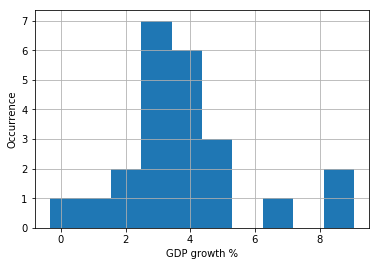

In [61]:
#We will first plot GDP, our independent variable, for a specific year, to see across our list of countries.
df_GDP['1999'].hist()
plt.xlabel('GDP growth %')
plt.ylabel('Occurrence')

### Economic Growth and Total Energy Use

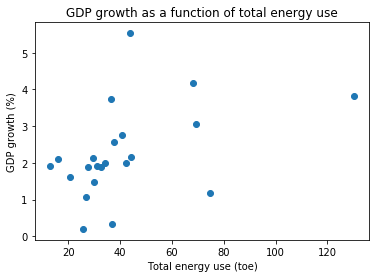

In [38]:
#We will plot based on GDP growth versus total imports, with each point representing a country's two datapoints. The variable will be the year. Feel free to change the year to see a different one.

df_GDP_plot = df_GDP["2005"]
df_IMP_plot = df_IMP["2005"]

plt.scatter(df_IMP_plot, df_GDP_plot)  
plt.title("GDP growth as a function of total energy use")
plt.xlabel("Total energy use (toe)")
plt.ylabel("GDP growth (%)")
plt.show()

In [50]:
#Derive correlation coefficient (rvalue)

linregress(df_IMP_plot, df_GDP_plot)

LinregressResult(slope=0.020904166707143016, intercept=1.3862594965205242, rvalue=0.42816584094337534, pvalue=0.046814324157968955, stderr=0.009865752451014023)

In [14]:
#There appears to be a weak positive correlation (rvalue = 0.43) between GDP growth and imports, implying that as imports rise as a % of GDP, so does GDP.

### Economic Growth and Primary School Spending

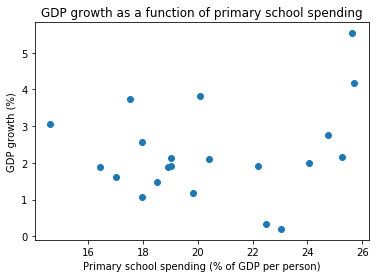

In [52]:
#We will plot based on GDP growth versus average expenditure per student, with each point representing a country's two datapoints. The variable will be the year. Feel free to change the year to see a different one.

df_GDP_plot = df_GDP["2005"]
df_EXP_plot = df_EXP["2005"]

plt.scatter(df_EXP_plot, df_GDP_plot)  
plt.title("GDP growth as a function of primary school spending")
plt.xlabel("Primary school spending (% of GDP per person)")
plt.ylabel("GDP growth (%)")
plt.show()

In [53]:
#Derive correlation coefficient (rvalue)

linregress(df_EXP_plot, df_GDP_plot)

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan)

In [22]:
#There appears to be no correlation between GDP growth and student expenditures, implying that as spending on primary school increases, GDP does not change.

### Economic Growth and Weekly Working Hours

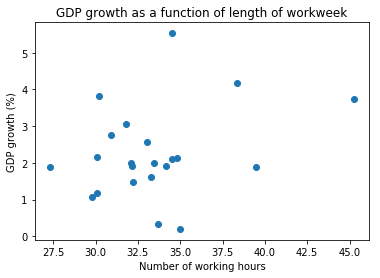

In [54]:
#We will plot based on GDP growth versus hours worked, with each point representing a country's two datapoints. The variable will be the year. Feel free to change the year to see a different one.

df_GDP_plot = df_GDP["2005"]
df_hours_plot = df_HOURS["2005"]

plt.scatter(df_hours_plot, df_GDP_plot)   
plt.title("GDP growth as a function of length of workweek")
plt.xlabel("Number of working hours")
plt.ylabel("GDP growth (%)")
plt.show()

In [57]:
#Derive correlation coefficient (rvalue)

linregress(df_hours_plot, df_GDP_plot)

LinregressResult(slope=0.09342185604239328, intercept=-0.8730823240166985, rvalue=0.28664271480502046, pvalue=0.19589482371126457, stderr=0.06981924016915173)

In [23]:
#There appears to be a weak positive correlation (rvalue = 0.29) between GDP growth and weekly work hours, implying that the more that the average worker works, the more GDP growth a country experiences.

<a id='conclusions'></a>
## Conclusions

> I started this project selecting datasets that I believed would correlate well together, and for the most part, the results were expected. Obviously, I cannot derive any causation between any two variables, as there are thousands of other variables to consider when looking at macro-level data such as GDP and any of the three other variables used. Additionally, these charts can only look at one year at a time, and some years do not seem to have any correlation at all.

> Limitations of the data I used are obvious: missing data. I started with more than 4 datasets, hoping to experiment with other interesting variables, but due to lack of matching countries, I had to limit to the 4 in the analysis. More specifically, I was unable to analyze countries that are historically known to be third-world or economically challenged, due to lack of data records. As a result, the vast majority of countries I studied are biased and skewed towards economically wealthy. Ideally, I would have an unbiased set of data for all countries.

> On the subject of total energy use, there appears to be a moderate positive correlation, implying that countries that consume more energy and spend more on education grow at faster clips.

> On the topic of primary school expenditures, there appears to not be a correlation at all, implying that increasing spending on primary school students as a % of GDP per capita does not result in higher GDP growth.

> On the topic of student weekly working hours, the correlation appears to be moderate throughout the years, implying that countries that push for full-time employment grow at faster clips. 

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [59]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0